# 02 - Preprocesamiento para Clasificación

In [ ]:
from pathlib import Path
import yaml
import obspy
import pandas as pd
import numpy as np
from scipy.signal import resample, welch
from scipy.stats import kurtosis, skew
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

✓ Librerías cargadas


In [ ]:
PROJECT_ROOT = Path.cwd().parent

with open(PROJECT_ROOT / "config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

DATA_ROOT = Path(cfg["paths"]["data_root"])
LABELED_DATA = Path(cfg["paths"]["labeled_data"])

FIGURES_DIR = PROJECT_ROOT / cfg["paths"]["figures_output"]
TABLES_DIR = PROJECT_ROOT / cfg["paths"]["tables_output"]
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

FIGURES_DIR.mkdir(exist_ok=True, parents=True)
TABLES_DIR.mkdir(exist_ok=True, parents=True)
PROCESSED_DIR.mkdir(exist_ok=True, parents=True)

print("PROJECT_ROOT :", PROJECT_ROOT)
print("LABELED_DATA :", LABELED_DATA)
print("PROCESSED_DIR:", PROCESSED_DIR)

PROJECT_ROOT : c:\Users\nicol\Documents\AAST_PJ\AAST_PJ
LABELED_DATA : E:\ckelar_label_data
PROCESSED_DIR: c:\Users\nicol\Documents\AAST_PJ\AAST_PJ\data\processed


In [ ]:
TARGET_FS = 200.0          
TARGET_LENGTH = 4000       
RANDOM_STATE = 42          


LABEL_MAP = {
    'VT': 0,   
    'LP': 1,   
    'TC': 2,   
    'TR': 3,   
    'HY': 4    
}

LABEL_NAMES = {v: k for k, v in LABEL_MAP.items()}

print("Parámetros de preprocesamiento:")
print(f"  - Frecuencia objetivo: {TARGET_FS} Hz")
print(f"  - Longitud objetivo: {TARGET_LENGTH} puntos")
print(f"  - Duración equivalente: {TARGET_LENGTH/TARGET_FS:.1f} segundos")
print(f"  - Clases: {list(LABEL_MAP.keys())}")

Parámetros de preprocesamiento:
  - Frecuencia objetivo: 200.0 Hz
  - Longitud objetivo: 4000 puntos
  - Duración equivalente: 20.0 segundos
  - Clases: ['VT', 'LP', 'TC', 'TR', 'HY']


## 1. Carga de Datos y Unificación de Frecuencia

In [4]:
def load_and_resample_event(filepath, target_fs=TARGET_FS):
    """
    Carga un evento sísmico y lo resamplea a la frecuencia objetivo.
    
    Returns:
        signal: np.array con la señal resampleada
        original_fs: frecuencia original
        duration: duración en segundos
    """
    st = obspy.read(str(filepath))
    tr = st[0]  # Tomamos el primer trace
    
    original_fs = tr.stats.sampling_rate
    duration = tr.stats.endtime - tr.stats.starttime
    signal = tr.data.astype(np.float32)
    
    # Resamplear si es necesario
    if original_fs != target_fs:
        # Calcular nuevo número de muestras
        new_npts = int(len(signal) * target_fs / original_fs)
        signal = resample(signal, new_npts)
    
    return signal, original_fs, float(duration)


def normalize_signal(signal):
    """
    Normaliza la señal a media 0 y desviación estándar 1.
    """
    mean = np.mean(signal)
    std = np.std(signal)
    if std > 0:
        return (signal - mean) / std
    return signal - mean


def resample_to_fixed_length(signal, target_length=TARGET_LENGTH):
    """
    Resamplea la señal a una longitud fija de puntos.
    Preserva la forma general pero normaliza la escala temporal.
    """
    return resample(signal, target_length)


print("✓ Funciones de carga definidas")

✓ Funciones de carga definidas


In [ ]:

print("Cargando y procesando eventos...\n")

data = {
    'signals_raw': [],           
    'signals_fixed': [],         
    'labels': [],                
    'label_names': [],           
    'durations': [],             
    'original_fs': [],           
    'original_npts': [],         
    'filenames': []              
}


for event_dir in sorted(LABELED_DATA.iterdir()):
    if not event_dir.is_dir():
        continue
    
    event_type = event_dir.name
    if event_type not in LABEL_MAP:
        print(f"  ⚠ Tipo desconocido: {event_type}, saltando...")
        continue
    
    mseed_files = [f for f in event_dir.iterdir() if f.is_file()]
    print(f"Procesando {event_type}: {len(mseed_files)} archivos")
    
    for mseed_file in tqdm(mseed_files, desc=f"  {event_type}", leave=False):
        try:
            
            signal, orig_fs, duration = load_and_resample_event(mseed_file)
            
            
            signal_norm = normalize_signal(signal)
            data['signals_raw'].append(signal_norm)
            
            
            signal_fixed = resample_to_fixed_length(signal_norm)
            data['signals_fixed'].append(signal_fixed)
            
            
            data['labels'].append(LABEL_MAP[event_type])
            data['label_names'].append(event_type)
            data['durations'].append(duration)
            data['original_fs'].append(orig_fs)
            data['original_npts'].append(len(signal))
            data['filenames'].append(mseed_file.name)
            
        except Exception as e:
            print(f"    ✗ Error en {mseed_file.name}: {e}")


X_fixed = np.array(data['signals_fixed'], dtype=np.float32)
y = np.array(data['labels'], dtype=np.int32)
durations = np.array(data['durations'], dtype=np.float32)

print(f"\n" + "="*60)
print(f"✓ Total de eventos procesados: {len(y)}")
print(f"✓ Shape de X_fixed: {X_fixed.shape}")
print(f"✓ Shape de y: {y.shape}")
print(f"✓ Distribución de clases:")
for label_name, label_idx in LABEL_MAP.items():
    count = np.sum(y == label_idx)
    print(f"    {label_name}: {count} ({count/len(y)*100:.1f}%)")

Cargando y procesando eventos...

Procesando HY: 213 archivos


Procesando LP: 577 archivos


Procesando TC: 2198 archivos


Procesando TR: 471 archivos


Procesando VT: 2686 archivos



✓ Total de eventos procesados: 6145
✓ Shape de X_fixed: (6145, 4000)
✓ Shape de y: (6145,)
✓ Distribución de clases:
    VT: 2686 (43.7%)
    LP: 577 (9.4%)
    TC: 2198 (35.8%)
    TR: 471 (7.7%)
    HY: 213 (3.5%)


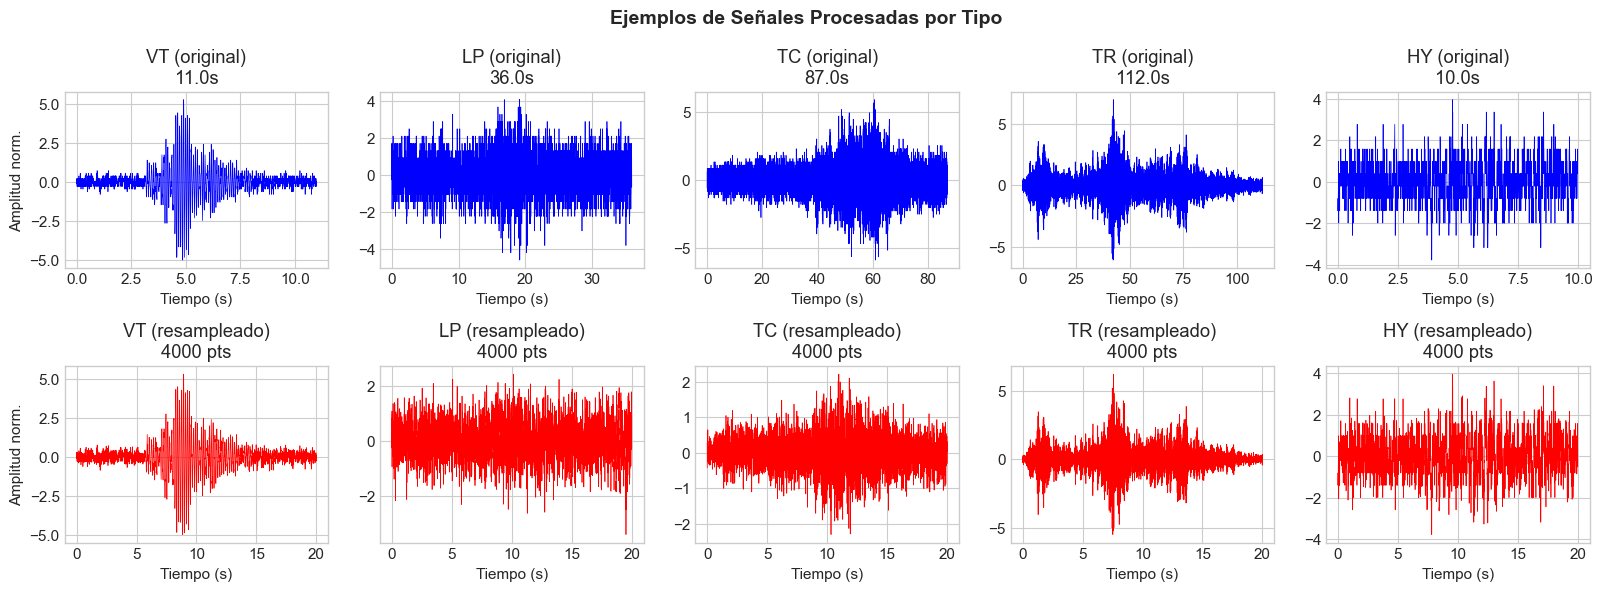

✓ Figura guardada en: c:\Users\nicol\Documents\AAST_PJ\AAST_PJ\figures\ejemplos_señales_procesadas.png


In [ ]:

fig, axes = plt.subplots(2, 5, figsize=(16, 6))
fig.suptitle('Ejemplos de Señales Procesadas por Tipo', fontsize=14, fontweight='bold')

for i, (label_name, label_idx) in enumerate(LABEL_MAP.items()):
    
    idx = np.where(y == label_idx)[0][0]
    
    
    ax_raw = axes[0, i]
    signal_raw = data['signals_raw'][idx]
    t_raw = np.arange(len(signal_raw)) / TARGET_FS
    ax_raw.plot(t_raw, signal_raw, 'b-', linewidth=0.5)
    ax_raw.set_title(f'{label_name} (original)\n{durations[idx]:.1f}s')
    ax_raw.set_xlabel('Tiempo (s)')
    if i == 0:
        ax_raw.set_ylabel('Amplitud norm.')
    
    
    ax_fixed = axes[1, i]
    t_fixed = np.arange(TARGET_LENGTH) / TARGET_FS
    ax_fixed.plot(t_fixed, X_fixed[idx], 'r-', linewidth=0.5)
    ax_fixed.set_title(f'{label_name} (resampleado)\n{TARGET_LENGTH} pts')
    ax_fixed.set_xlabel('Tiempo (s)')
    if i == 0:
        ax_fixed.set_ylabel('Amplitud norm.')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'ejemplos_señales_procesadas.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Figura guardada en: {FIGURES_DIR / 'ejemplos_señales_procesadas.png'}")

## 2. Extracción de Features para Modelos Baseline


In [ ]:




def extract_temporal_features(signal, fs=TARGET_FS):
    """
    Extrae features del dominio temporal.
    """
    features = {}
    
    
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['rms'] = np.sqrt(np.mean(signal**2))
    features['max_abs'] = np.max(np.abs(signal))
    features['min_val'] = np.min(signal)
    features['max_val'] = np.max(signal)
    features['peak_to_peak'] = features['max_val'] - features['min_val']
    
    
    features['skewness'] = skew(signal)
    features['kurtosis'] = kurtosis(signal)
    
    
    zero_crossings = np.sum(np.abs(np.diff(np.sign(signal))) > 0)
    features['zcr'] = zero_crossings / len(signal)
    
    
    features['energy'] = np.sum(signal**2)
    features['log_energy'] = np.log(features['energy'] + 1e-10)
    
    
    features['p10'] = np.percentile(np.abs(signal), 10)
    features['p25'] = np.percentile(np.abs(signal), 25)
    features['p75'] = np.percentile(np.abs(signal), 75)
    features['p90'] = np.percentile(np.abs(signal), 90)
    
    return features


def extract_frequency_features(signal, fs=TARGET_FS):
    """
    Extrae features del dominio frecuencial.
    """
    features = {}
    
    
    nperseg = min(256, len(signal) // 4)
    freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
    
    
    psd_norm = psd / (np.sum(psd) + 1e-10)
    
    
    features['freq_dominant'] = freqs[np.argmax(psd)]
    
    
    features['spectral_centroid'] = np.sum(freqs * psd_norm)
    
    
    features['spectral_bandwidth'] = np.sqrt(
        np.sum(((freqs - features['spectral_centroid'])**2) * psd_norm)
    )
    
    
    cumsum = np.cumsum(psd_norm)
    rolloff_idx = np.searchsorted(cumsum, 0.85)
    features['spectral_rolloff'] = freqs[min(rolloff_idx, len(freqs)-1)]
    
    
    geometric_mean = np.exp(np.mean(np.log(psd + 1e-10)))
    arithmetic_mean = np.mean(psd)
    features['spectral_flatness'] = geometric_mean / (arithmetic_mean + 1e-10)
    
    
    
    band_edges = [0, 1, 2, 5, 10, 20, 50, fs/2]
    for i in range(len(band_edges) - 1):
        f_low, f_high = band_edges[i], band_edges[i+1]
        mask = (freqs >= f_low) & (freqs < f_high)
        band_energy = np.sum(psd[mask]) if np.any(mask) else 0
        features[f'energy_band_{f_low}_{f_high}hz'] = band_energy
    
    
    lf_mask = freqs < 5
    hf_mask = freqs >= 5
    lf_energy = np.sum(psd[lf_mask]) if np.any(lf_mask) else 0
    hf_energy = np.sum(psd[hf_mask]) if np.any(hf_mask) else 0
    features['lf_hf_ratio'] = lf_energy / (hf_energy + 1e-10)
    
    return features


def extract_envelope_features(signal, fs=TARGET_FS):
    """
    Extrae features de la envolvente de la señal.
    """
    from scipy.signal import hilbert
    
    features = {}
    
    
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    
    
    max_idx = np.argmax(envelope)
    max_time = max_idx / fs
    total_time = len(signal) / fs
    
    
    features['rise_time'] = max_time
    features['rise_time_ratio'] = max_time / total_time
    
    
    features['decay_time'] = total_time - max_time
    features['decay_ratio'] = features['decay_time'] / total_time
    
    
    features['envelope_mean'] = np.mean(envelope)
    features['envelope_std'] = np.std(envelope)
    features['envelope_max'] = np.max(envelope)
    features['envelope_skew'] = skew(envelope)
    features['envelope_kurtosis'] = kurtosis(envelope)
    
    
    features['crest_factor'] = features['envelope_max'] / (np.sqrt(np.mean(envelope**2)) + 1e-10)
    
    return features


def extract_all_features(signal, duration, fs=TARGET_FS):
    """
    Extrae todas las features de una señal.
    """
    features = {}
    
    
    features['duration'] = duration
    features['log_duration'] = np.log(duration + 1e-10)
    
    
    features.update(extract_temporal_features(signal, fs))
    
    
    features.update(extract_frequency_features(signal, fs))
    
    
    features.update(extract_envelope_features(signal, fs))
    
    return features


print("✓ Funciones de extracción de features definidas")

✓ Funciones de extracción de features definidas


In [ ]:

print("Extrayendo features de todos los eventos...\n")

all_features = []

for i in tqdm(range(len(data['signals_raw'])), desc="Extrayendo features"):
    signal = data['signals_raw'][i]
    duration = data['durations'][i]
    
    features = extract_all_features(signal, duration)
    features['label'] = data['labels'][i]
    features['label_name'] = data['label_names'][i]
    features['filename'] = data['filenames'][i]
    
    all_features.append(features)


df_features = pd.DataFrame(all_features)

print(f"\n✓ Features extraídas: {df_features.shape[0]} eventos, {df_features.shape[1]} columnas")
print(f"\nFeatures disponibles ({len(df_features.columns) - 3} features + 3 metadatos):")

feature_cols = [c for c in df_features.columns if c not in ['label', 'label_name', 'filename']]
for i, col in enumerate(feature_cols):
    print(f"  {i+1:2d}. {col}")

Extrayendo features de todos los eventos...



Extrayendo features: 100%|██████████| 6145/6145 [00:45<00:00, 134.18it/s]



✓ Features extraídas: 6145 eventos, 44 columnas

Features disponibles (41 features + 3 metadatos):
   1. duration
   2. log_duration
   3. mean
   4. std
   5. rms
   6. max_abs
   7. min_val
   8. max_val
   9. peak_to_peak
  10. skewness
  11. kurtosis
  12. zcr
  13. energy
  14. log_energy
  15. p10
  16. p25
  17. p75
  18. p90
  19. freq_dominant
  20. spectral_centroid
  21. spectral_bandwidth
  22. spectral_rolloff
  23. spectral_flatness
  24. energy_band_0_1hz
  25. energy_band_1_2hz
  26. energy_band_2_5hz
  27. energy_band_5_10hz
  28. energy_band_10_20hz
  29. energy_band_20_50hz
  30. energy_band_50_100.0hz
  31. lf_hf_ratio
  32. rise_time
  33. rise_time_ratio
  34. decay_time
  35. decay_ratio
  36. envelope_mean
  37. envelope_std
  38. envelope_max
  39. envelope_skew
  40. envelope_kurtosis
  41. crest_factor


In [ ]:

print("="*70)
print("ESTADÍSTICAS DE FEATURES POR CLASE")
print("="*70)


key_features = ['duration', 'rms', 'freq_dominant', 'spectral_centroid', 
                'lf_hf_ratio', 'rise_time_ratio', 'kurtosis', 'zcr']

summary_stats = df_features.groupby('label_name')[key_features].agg(['mean', 'std']).round(3)
print(summary_stats)

ESTADÍSTICAS DE FEATURES POR CLASE
           duration          rms      freq_dominant         spectral_centroid  \
               mean     std mean  std          mean     std              mean   
label_name                                                                      
HY           57.197  35.310  1.0  0.0        14.536  16.800            21.361   
LP           82.275  63.510  1.0  0.0         8.946  15.731            19.004   
TC           78.532  56.238  1.0  0.0        10.625  11.019            17.361   
TR           46.193  33.781  1.0  0.0        13.810   8.647            18.751   
VT           19.605  12.321  1.0  0.0        13.771   6.687            18.461   

                   lf_hf_ratio        rise_time_ratio        kurtosis          \
               std        mean    std            mean    std     mean     std   
label_name                                                                      
HY          10.191       0.222  0.241           0.259  0.189    4.832   6

## 3. Análisis de Correlación de Features

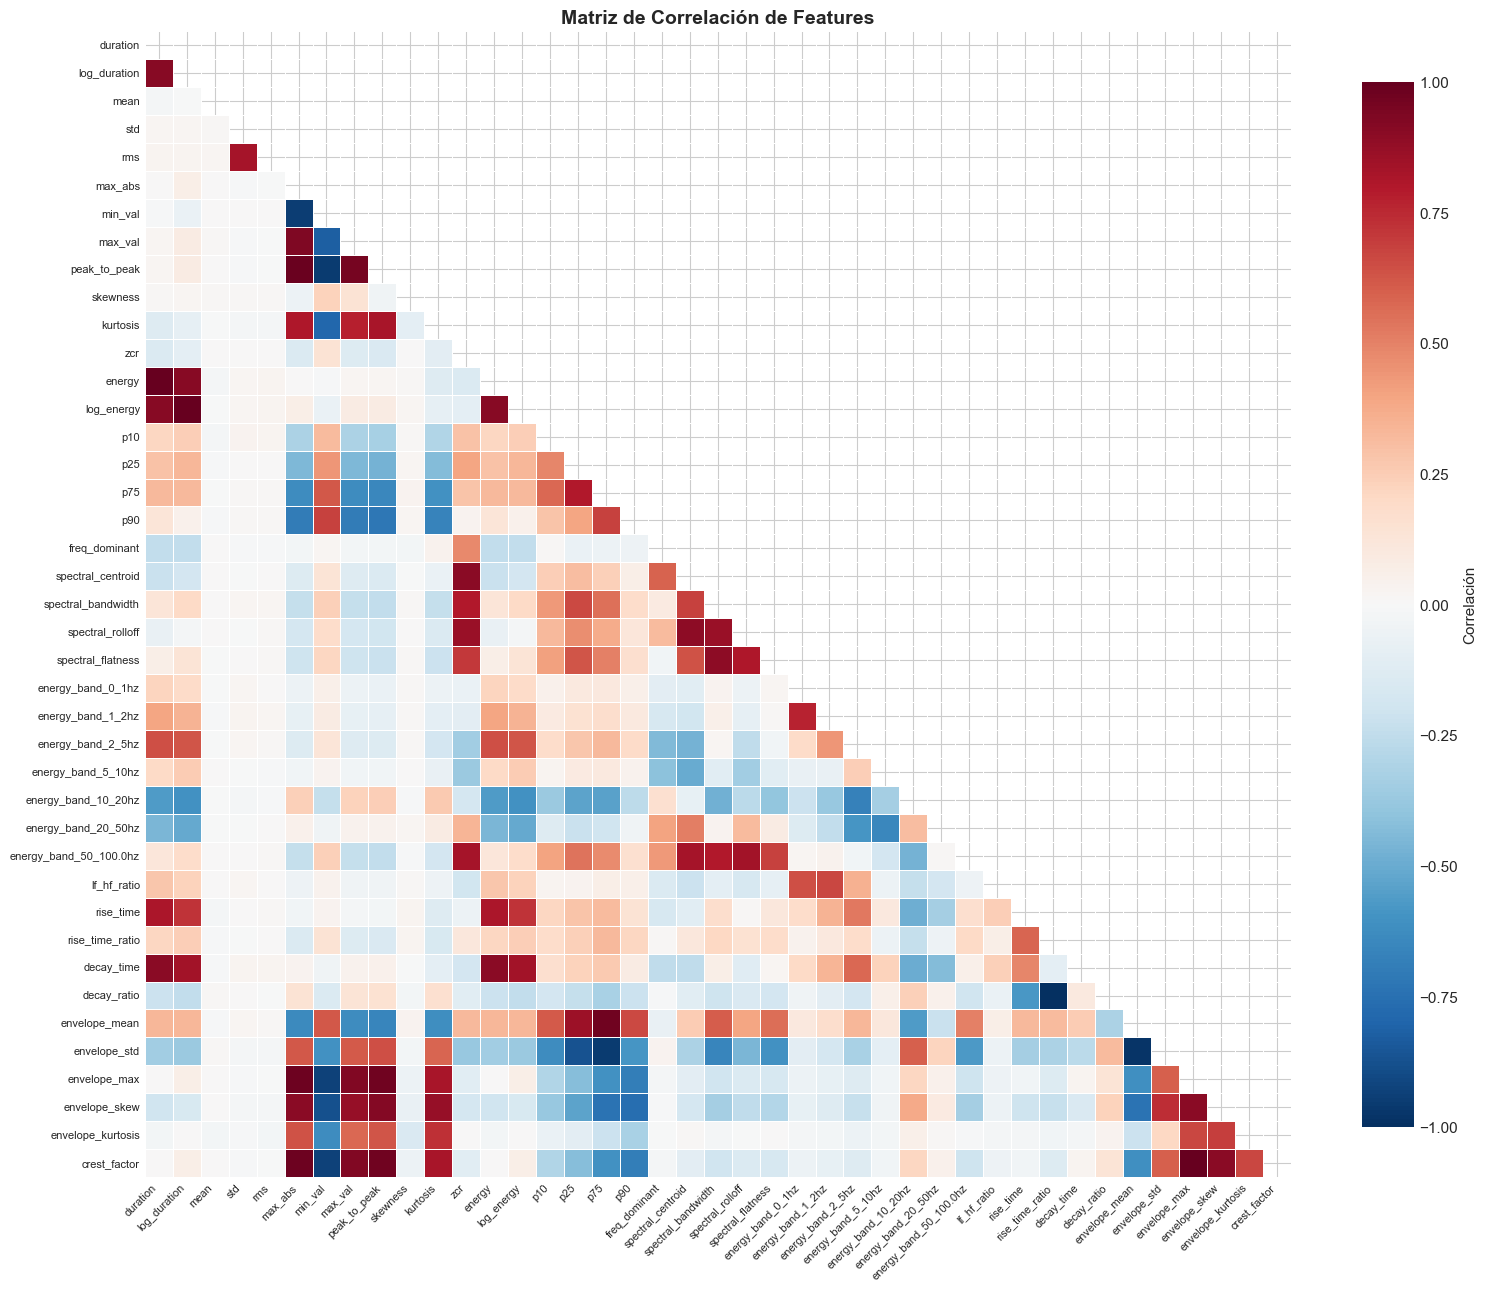

✓ Figura guardada en: c:\Users\nicol\Documents\AAST_PJ\AAST_PJ\figures\correlacion_features.png


In [ ]:

feature_cols = [c for c in df_features.columns if c not in ['label', 'label_name', 'filename']]
correlation_matrix = df_features[feature_cols].corr()


fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, cmap='RdBu_r', center=0,
            annot=False, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Correlación'},
            ax=ax)

ax.set_title('Matriz de Correlación de Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'correlacion_features.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Figura guardada en: {FIGURES_DIR / 'correlacion_features.png'}")

In [ ]:

print("="*70)
print("FEATURES ALTAMENTE CORRELACIONADAS (|r| > 0.9)")
print("="*70)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.9:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlación': corr_val
            })

df_high_corr = pd.DataFrame(high_corr_pairs).sort_values('Correlación', key=abs, ascending=False)
print(df_high_corr.to_string(index=False))

print(f"\n⚠ {len(high_corr_pairs)} pares de features con correlación > 0.9")
print("  Considerar eliminar redundantes para modelos baseline")

FEATURES ALTAMENTE CORRELACIONADAS (|r| > 0.9)
      Feature 1         Feature 2  Correlación
rise_time_ratio       decay_ratio    -1.000000
       duration            energy     1.000000
   log_duration        log_energy     1.000000
   envelope_max      crest_factor     1.000000
        max_abs      peak_to_peak     0.985479
  envelope_mean      envelope_std    -0.984227
        max_abs      envelope_max     0.977533
        max_abs      crest_factor     0.977530
   peak_to_peak      envelope_max     0.973504
   peak_to_peak      crest_factor     0.973501
            p75     envelope_mean     0.971294
        min_val      peak_to_peak    -0.955354
        max_val      peak_to_peak     0.953626
            p75      envelope_std    -0.953203
        max_abs           min_val    -0.946160
        min_val      envelope_max    -0.935806
        min_val      crest_factor    -0.935801
        max_abs           max_val     0.935014
        max_val      envelope_max     0.922487
        max_v

In [ ]:

def remove_highly_correlated(df, threshold=0.9):
    """
    Elimina features altamente correlacionadas manteniendo una de cada par.
    """
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return df.drop(columns=to_drop), to_drop


df_features_reduced, dropped_features = remove_highly_correlated(
    df_features[feature_cols], threshold=0.9
)

print(f"Features originales: {len(feature_cols)}")
print(f"Features eliminadas: {len(dropped_features)}")
print(f"Features finales: {len(df_features_reduced.columns)}")
print(f"\nFeatures eliminadas por redundancia:")
for f in dropped_features:
    print(f"  - {f}")

Features originales: 41
Features eliminadas: 14
Features finales: 27

Features eliminadas por redundancia:
  - log_duration
  - min_val
  - max_val
  - peak_to_peak
  - energy
  - log_energy
  - spectral_centroid
  - decay_time
  - decay_ratio
  - envelope_mean
  - envelope_std
  - envelope_max
  - envelope_skew
  - crest_factor


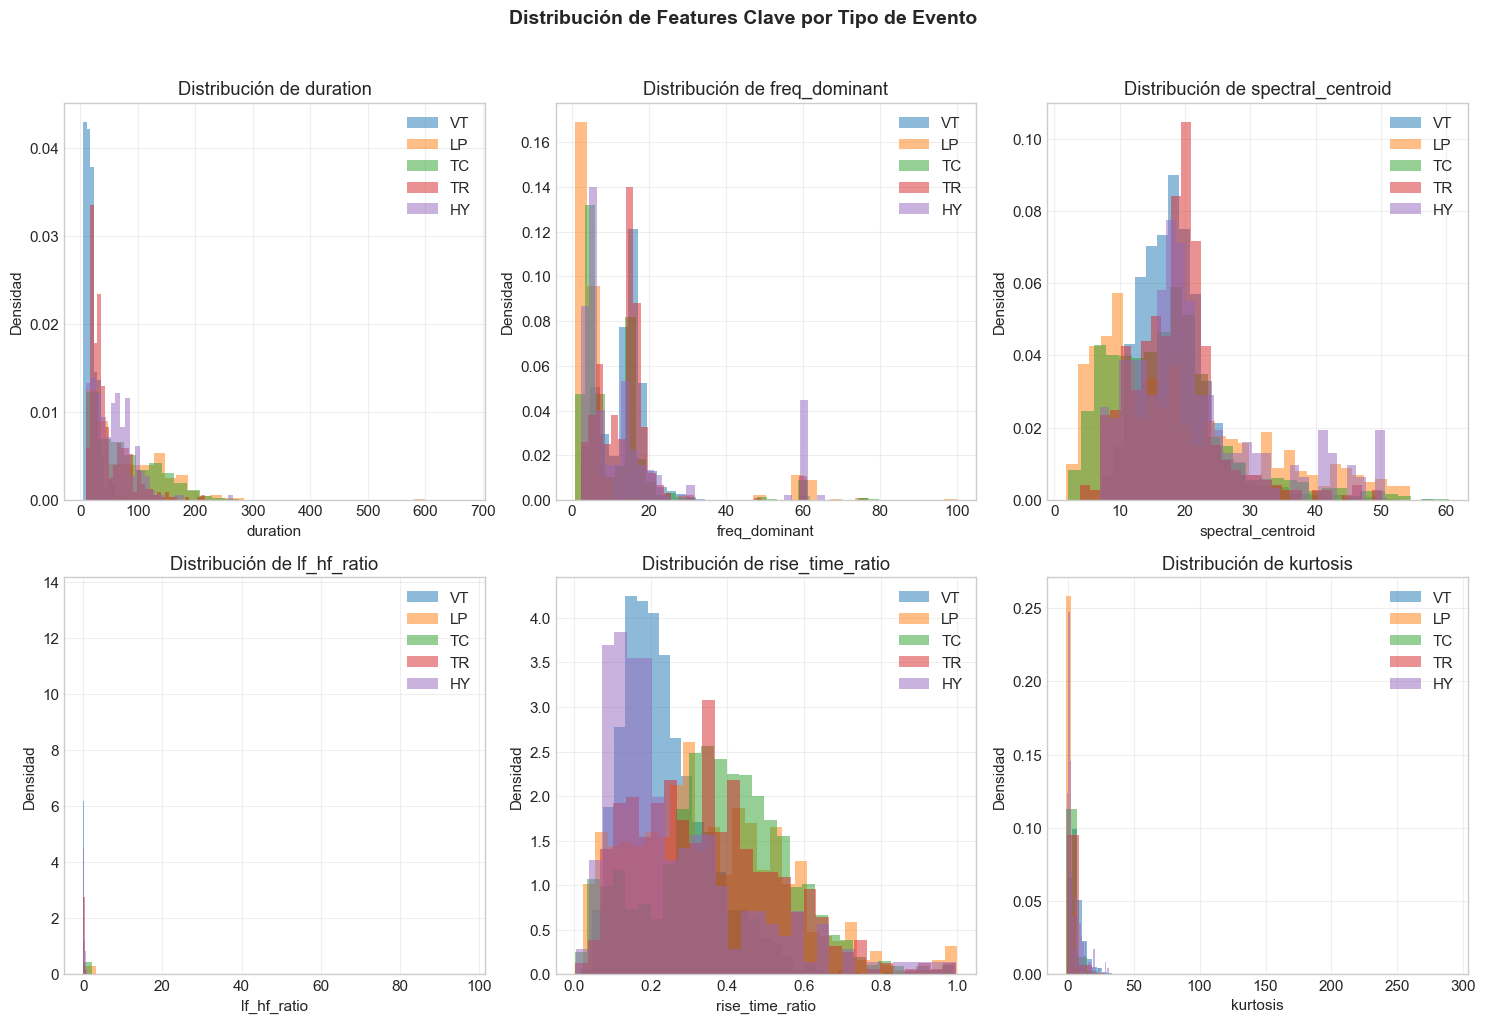

✓ Figura guardada en: c:\Users\nicol\Documents\AAST_PJ\AAST_PJ\figures\distribucion_features_clave.png


In [ ]:

key_features_plot = ['duration', 'freq_dominant', 'spectral_centroid', 
                     'lf_hf_ratio', 'rise_time_ratio', 'kurtosis']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features_plot):
    ax = axes[i]
    
    for label_name in LABEL_MAP.keys():
        subset = df_features[df_features['label_name'] == label_name][feature]
        ax.hist(subset, alpha=0.5, label=label_name, bins=30, density=True)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Densidad')
    ax.set_title(f'Distribución de {feature}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribución de Features Clave por Tipo de Evento', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'distribucion_features_clave.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Figura guardada en: {FIGURES_DIR / 'distribucion_features_clave.png'}")

## 4. Preparación Final de Datos para Clasificación

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
selected_features = df_features_reduced.columns.tolist()
X_baseline = df_features[selected_features].values
y_baseline = df_features['label'].values


X_train_bl, X_temp_bl, y_train_bl, y_temp_bl = train_test_split(
    X_baseline, y_baseline, test_size=0.3, random_state=RANDOM_STATE, stratify=y_baseline
)
X_val_bl, X_test_bl, y_val_bl, y_test_bl = train_test_split(
    X_temp_bl, y_temp_bl, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp_bl
)


scaler_baseline = StandardScaler()
X_train_bl_scaled = scaler_baseline.fit_transform(X_train_bl)
X_val_bl_scaled = scaler_baseline.transform(X_val_bl)
X_test_bl_scaled = scaler_baseline.transform(X_test_bl)

print("DATOS PARA BASELINE (FEATURES):")
print(f"  Train: {X_train_bl_scaled.shape}")
print(f"  Val:   {X_val_bl_scaled.shape}")
print(f"  Test:  {X_test_bl_scaled.shape}")

DATOS PARA BASELINE (FEATURES):
  Train: (4301, 27)
  Val:   (922, 27)
  Test:  (922, 27)


In [ ]:
X_dl = X_fixed.reshape(-1, TARGET_LENGTH, 1)  
y_dl = y


durations_normalized = (durations - durations.mean()) / durations.std()


indices = np.arange(len(y_dl))
train_idx, temp_idx = train_test_split(
    indices, test_size=0.3, random_state=RANDOM_STATE, stratify=y_dl
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=RANDOM_STATE, stratify=y_dl[temp_idx]
)


X_train_dl = X_dl[train_idx]
X_val_dl = X_dl[val_idx]
X_test_dl = X_dl[test_idx]

y_train_dl = y_dl[train_idx]
y_val_dl = y_dl[val_idx]
y_test_dl = y_dl[test_idx]


dur_train = durations_normalized[train_idx]
dur_val = durations_normalized[val_idx]
dur_test = durations_normalized[test_idx]

print("\nDATOS PARA DEEP LEARNING (SECUENCIAS):")
print(f"  X_train: {X_train_dl.shape}")
print(f"  X_val:   {X_val_dl.shape}")
print(f"  X_test:  {X_test_dl.shape}")
print(f"\n  dur_train: {dur_train.shape}")
print(f"  dur_val:   {dur_val.shape}")
print(f"  dur_test:  {dur_test.shape}")


DATOS PARA DEEP LEARNING (SECUENCIAS):
  X_train: (4301, 4000, 1)
  X_val:   (922, 4000, 1)
  X_test:  (922, 4000, 1)

  dur_train: (4301,)
  dur_val:   (922,)
  dur_test:  (922,)


In [ ]:

print("="*70)
print("DISTRIBUCIÓN DE CLASES EN SPLITS")
print("="*70)

def print_class_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n{name}:")
    for label_idx, count in zip(unique, counts):
        label_name = LABEL_NAMES[label_idx]
        print(f"  {label_name}: {count:4d} ({count/len(y)*100:5.1f}%)")

print_class_distribution(y_train_dl, "Train")
print_class_distribution(y_val_dl, "Validation")
print_class_distribution(y_test_dl, "Test")

DISTRIBUCIÓN DE CLASES EN SPLITS

Train:
  VT: 1880 ( 43.7%)
  LP:  404 (  9.4%)
  TC: 1538 ( 35.8%)
  TR:  330 (  7.7%)
  HY:  149 (  3.5%)

Validation:
  VT:  403 ( 43.7%)
  LP:   86 (  9.3%)
  TC:  330 ( 35.8%)
  TR:   71 (  7.7%)
  HY:   32 (  3.5%)

Test:
  VT:  403 ( 43.7%)
  LP:   87 (  9.4%)
  TC:  330 ( 35.8%)
  TR:   70 (  7.6%)
  HY:   32 (  3.5%)


## 5. Guardar Datos Procesados

In [ ]:
np.savez_compressed(
    PROCESSED_DIR / 'baseline_features.npz',
    X_train=X_train_bl_scaled,
    X_val=X_val_bl_scaled,
    X_test=X_test_bl_scaled,
    y_train=y_train_bl,
    y_val=y_val_bl,
    y_test=y_test_bl,
    feature_names=np.array(selected_features),
    label_map=np.array(list(LABEL_MAP.items()))
)
print(f"✓ Guardado: {PROCESSED_DIR / 'baseline_features.npz'}")


np.savez_compressed(
    PROCESSED_DIR / 'sequences_fixed_length.npz',
    X_train=X_train_dl,
    X_val=X_val_dl,
    X_test=X_test_dl,
    y_train=y_train_dl,
    y_val=y_val_dl,
    y_test=y_test_dl,
    dur_train=dur_train,
    dur_val=dur_val,
    dur_test=dur_test,
    target_length=TARGET_LENGTH,
    target_fs=TARGET_FS,
    label_map=np.array(list(LABEL_MAP.items()))
)
print(f"✓ Guardado: {PROCESSED_DIR / 'sequences_fixed_length.npz'}")


df_features.to_csv(PROCESSED_DIR / 'features_complete.csv', index=False)
print(f"✓ Guardado: {PROCESSED_DIR / 'features_complete.csv'}")


import joblib
joblib.dump(scaler_baseline, PROCESSED_DIR / 'scaler_baseline.pkl')
print(f"✓ Guardado: {PROCESSED_DIR / 'scaler_baseline.pkl'}")


np.savez(
    PROCESSED_DIR / 'split_indices.npz',
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx
)
print(f"✓ Guardado: {PROCESSED_DIR / 'split_indices.npz'}")

✓ Guardado: c:\Users\nicol\Documents\AAST_PJ\AAST_PJ\data\processed\baseline_features.npz
✓ Guardado: c:\Users\nicol\Documents\AAST_PJ\AAST_PJ\data\processed\sequences_fixed_length.npz
✓ Guardado: c:\Users\nicol\Documents\AAST_PJ\AAST_PJ\data\processed\features_complete.csv
✓ Guardado: c:\Users\nicol\Documents\AAST_PJ\AAST_PJ\data\processed\scaler_baseline.pkl
✓ Guardado: c:\Users\nicol\Documents\AAST_PJ\AAST_PJ\data\processed\split_indices.npz
